In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import seaborn as sns

from src.est import *
from src.utils import *

# 1 - Prepare data

In [2]:
df_trips = pd.read_parquet("data/yellow_tripdata_2024-01.parquet")
df_zones = pd.read_csv("data/taxi_zones.csv")

In [3]:
def get_longitude(polygon):
    multipolygon = wkt.loads(polygon)
    centroid = multipolygon.centroid
    longitude = centroid.x
    return longitude

def get_latitude(polygon):
    multipolygon = wkt.loads(polygon)
    centroid = multipolygon.centroid
    latitude = centroid.y
    return latitude

df_zones['lon'] = df_zones['the_geom'].apply(get_longitude)
df_zones['lat'] = df_zones['the_geom'].apply(get_latitude)

df_trips['tpep_pickup_datetime'] = pd.to_datetime(df_trips['tpep_pickup_datetime'])
df_trips['tpep_dropoff_datetime'] = pd.to_datetime(df_trips['tpep_dropoff_datetime'])
df_trips['PUhour'] = df_trips['tpep_pickup_datetime'].dt.hour // 4
df_trips['DOhour'] = df_trips['tpep_dropoff_datetime'].dt.hour // 4

def categorize_time(hour):
    if 6 <= hour <= 11:
        return 0
    elif 12 <= hour <= 17:
        return 1
    else:
        return 2

df_trips['PUtime_period'] = df_trips['PUhour'].apply(categorize_time)
df_trips['DOtime_period'] = df_trips['DOhour'].apply(categorize_time)

df_trips = df_trips.merge(
    df_zones[['LocationID', 'borough', 'zone', 'lon', 'lat']], 
    left_on='PULocationID', 
    right_on='LocationID', 
    suffixes=('', '_PU')
)
df_trips.rename(columns={'lon': 'PUlon', 'lat': 'PUlat', 'borough': 'PUborough', 'zone': 'PUzone'}, inplace=True)

df_trips = df_trips.merge(
    df_zones[['LocationID', 'borough', 'zone', 'lon', 'lat']], 
    left_on='DOLocationID', 
    right_on='LocationID', 
    suffixes=('', '_DO')
)
df_trips.rename(columns={'lon': 'DOlon', 'lat': 'DOlat', 'borough': 'DOborough', 'zone': 'DOzone'}, inplace=True)

df_trips.drop(columns=['LocationID', 'LocationID_DO'], inplace=True)

In [4]:
neighborhoods_south_of_harlem = [
    'Alphabet City', 'Battery Park', 'Battery Park City', 'Central Park',
    'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 
    'East Village', 'Financial District North', 'Financial District South', 
    'Flatiron', 'Hudson Sq', 'Garment District', 
    "Governor's Island/Ellis Island/Liberty Island", 'Gramercy', 
    'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 
    'Lincoln Square West', 'Little Italy/NoLiTa', 'Lower East Side', 
    'Meatpacking/West Village West', 'Midtown Center', 'Midtown East', 
    'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'Seaport', 'SoHo', 
    'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North', 
    'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'Two Bridges/Seward Park', 'UN/Turtle Bay South', 'Union Sq', 
    'Upper East Side North', 'Upper East Side South', 'Upper West Side South', 
    'Washington Heights South', 'West Chelsea/Hudson Yards', 'West Village', 
    'World Trade Center', 'Yorkville East', 'Yorkville West'
]

neighborhoods_from_central_park_to_south = [
    'Alphabet City', 'Battery Park', 'Battery Park City', 'Central Park',
    'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 
    'East Village', 'Financial District North', 'Financial District South', 
    'Flatiron', 'Hudson Sq', 'Garment District', 
    "Governor's Island/Ellis Island/Liberty Island", 'Gramercy', 
    'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 
    'Lincoln Square West', 'Little Italy/NoLiTa', 'Lower East Side', 
    'Meatpacking/West Village West', 'Midtown Center', 'Midtown East', 
    'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'Seaport', 'SoHo', 
    'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North', 
    'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'Two Bridges/Seward Park', 'UN/Turtle Bay South', 'Union Sq', 
    'Upper East Side North', 'Upper East Side South', 'Upper West Side South', 
    'West Chelsea/Hudson Yards', 'West Village', 'World Trade Center', 
    'Yorkville East', 'Yorkville West'
]

neighborhoods_central_park_to_north_of_battery_park = [
    'Alphabet City', 'Central Park', 'Chinatown', 'Clinton East', 'Clinton West', 
    'East Chelsea', 'East Village', 'Flatiron', 'Hudson Sq', 'Garment District', 
    'Gramercy', 'Greenwich Village North', 'Greenwich Village South', 'Kips Bay', 
    'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East', 'Lincoln Square West', 
    'Little Italy/NoLiTa', 'Lower East Side', 'Meatpacking/West Village West', 
    'Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South', 'Murray Hill', 
    'Penn Station/Madison Sq West', 'SoHo', 'Stuy Town/Peter Cooper Village', 
    'Sutton Place/Turtle Bay North', 'Times Sq/Theatre District', 'TriBeCa/Civic Center', 
    'UN/Turtle Bay South', 'Union Sq', 'Upper East Side North', 'Upper East Side South', 
    'Upper West Side South', 'West Chelsea/Hudson Yards', 'West Village', 'Yorkville East', 
    'Yorkville West'
]

df_trips_manhattan = df_trips[
    (df_trips['PUborough'] == 'Manhattan') & 
    (df_trips['DOborough'] == 'Manhattan') & 
    (df_trips['PUzone'].isin(neighborhoods_from_central_park_to_south)) & 
    (df_trips['DOzone'].isin(neighborhoods_from_central_park_to_south))
].copy()

df_trips_manhattan = df_trips[
    (df_trips['PUborough'] == 'Manhattan') & 
    (df_trips['DOborough'] == 'Manhattan')
].copy()

unique_pu_ids = set(df_trips_manhattan['PULocationID'].unique())
unique_do_ids = set(df_trips_manhattan['DOLocationID'].unique())

common_location_ids = unique_pu_ids.intersection(unique_do_ids)

df_trips_manhattan = df_trips_manhattan[
    (df_trips_manhattan['PULocationID'].isin(common_location_ids)) &
    (df_trips_manhattan['DOLocationID'].isin(common_location_ids))
].copy()

df_trips_manhattan['PULocationID'], pu_id_mapping = pd.factorize(df_trips_manhattan['PULocationID'])
df_trips_manhattan['DOLocationID'], do_id_mapping = pd.factorize(df_trips_manhattan['DOLocationID'])

df_trips_manhattan['PULocationID'] += 1
df_trips_manhattan['DOLocationID'] += 1

### Geo-coordinates

In [5]:
angle_degrees = -29
angle_radians = np.radians(angle_degrees)

rotation_matrix = np.array([
    [np.cos(angle_radians), -np.sin(angle_radians)],
    [np.sin(angle_radians), np.cos(angle_radians)]
])

df_trips_manhattan[['PUlon_rot', 'PUlat_rot']] = df_trips_manhattan[['PUlon', 'PUlat']].dot(rotation_matrix)
df_trips_manhattan[['DOlon_rot', 'DOlat_rot']] = df_trips_manhattan[['DOlon', 'DOlat']].dot(rotation_matrix)

In [6]:
n_bins = 10

min_rot_lon = min(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].min())
max_rot_lon = max(df_trips_manhattan[['PUlon_rot', 'DOlon_rot']].max())
min_rot_lat = min(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].min())
max_rot_lat = max(df_trips_manhattan[['PUlat_rot', 'DOlat_rot']].max())

df_trips_manhattan['PUlon_bin'] = pd.cut(df_trips_manhattan['PUlon_rot'], bins=n_bins, labels=False)
df_trips_manhattan['PUlat_bin'] = pd.cut(df_trips_manhattan['PUlat_rot'], bins=n_bins, labels=False)
df_trips_manhattan['DOlon_bin'] = pd.cut(df_trips_manhattan['DOlon_rot'], bins=n_bins, labels=False)
df_trips_manhattan['DOlat_bin'] = pd.cut(df_trips_manhattan['DOlat_rot'], bins=n_bins, labels=False)

### Period - ID

In [56]:
n_periods = 6  # 24 bins for each hour of the day
n_locations = df_trips_manhattan['PULocationID'].nunique()  # Number of unique locations

M_ten = np.zeros((n_periods, n_locations))  # Marginal probability of pickup states
Q_ten = np.zeros((n_periods, n_locations, n_periods, n_locations))  # Joint distribution of transitions
P = np.zeros((n_periods, n_locations, n_periods, n_locations))  # Conditional transition probabilities

for _, row in df_trips_manhattan.iterrows():
    pu_period_idx = int(row['PUhour'])  # Pickup hour index (0-23)
    pu_loc_idx = int(row['PULocationID']) - 1  # Assuming LocationID is 1-indexed
    do_period_idx = int(row['DOhour'])  # Dropoff hour index (0-23)
    do_loc_idx = int(row['DOLocationID']) - 1  # Assuming LocationID is 1-indexed

    M_ten[pu_period_idx, pu_loc_idx] += 1

    Q_ten[pu_period_idx, pu_loc_idx, do_period_idx, do_loc_idx] += 1

M_ten_sum = M_ten.sum()
if M_ten_sum > 0:
    M_ten = M_ten / M_ten_sum

M_vec = M_ten.flatten()

Q_ten_sum = Q_ten.sum()
if Q_ten_sum > 0:
    Q_ten = Q_ten / Q_ten_sum

P_sum = Q_ten.sum(axis=(2, 3), keepdims=True)  # Sum over next states for normalization
P_sum[P_sum == 0] = 1  # Avoid division by zero
P_ten = Q_ten / P_sum  # Conditional probability

Q_mat = Q_ten.reshape(n_periods * n_locations, n_periods * n_locations)
P_mat = P_ten.reshape(n_periods * n_locations, n_periods * n_locations)

# 2 - Visualizations

In [17]:
coordinates = df_trips_manhattan[['PUlon', 'PUlat']].drop_duplicates().values

<Figure size 1000x1000 with 0 Axes>

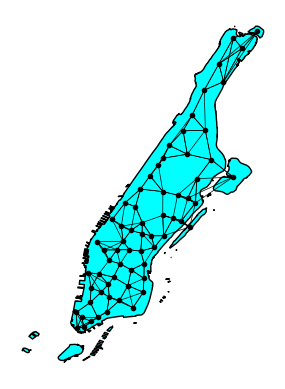

In [63]:
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import KDTree

coordinates = df_trips_manhattan[['PUlon', 'PUlat']].drop_duplicates().values

manhattan_url = 'https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson'
manhattan_gdf = gpd.read_file(manhattan_url)
manhattan_gdf = manhattan_gdf[manhattan_gdf['boro_name'] == 'Manhattan']

plt.figure(figsize=(10, 10))

ax = manhattan_gdf.plot(color='cyan', edgecolor='black')
ax.set_axis_off()

plt.gca().set_aspect('equal', adjustable='box')

tree = KDTree(coordinates)
for coord in coordinates:
    plt.plot(coord[0], coord[1], 'o', markersize=3, color='black')
    _, idx = tree.query(coord, k=5)  # Increase the number of nearest neighbors to 5
    nearest_coords = coordinates[idx[1:]]  # Skip the first index as it's the point itself
    for nearest_coord in nearest_coords:
        plt.plot([coord[0], nearest_coord[0]], [coord[1], nearest_coord[1]], '-', color='black', linewidth=0.5)

plt.savefig('results/1_manhattan', dpi=300)


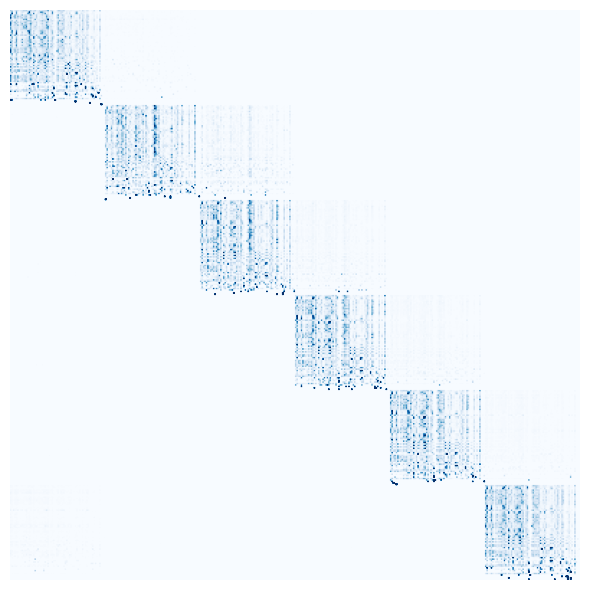

In [62]:
plt.figure(figsize=(12, 6))

plt.imshow(P_mat, cmap='Blues', vmin=0, vmax=0.1)
plt.axis('off')

plt.tight_layout()
plt.savefig('results/2_p_ground_truth', dpi=300)

# 3 - Estimation

In [39]:
def get_chain(df, n):
    M_ten = np.zeros((n_periods, n_locations))  # Marginal probability of pickup states
    Q_ten = np.zeros((n_periods, n_locations, n_periods, n_locations))  # Joint distribution of transitions

    for _, row in df.sample(n=n).iterrows():
        pu_period_idx = int(row['PUhour'])  # Pickup hour index (0-23)
        pu_loc_idx = int(row['PULocationID']) - 1  # Assuming LocationID is 1-indexed
        do_period_idx = int(row['DOhour'])  # Dropoff hour index (0-23)
        do_loc_idx = int(row['DOLocationID']) - 1  # Assuming LocationID is 1-indexed

        M_ten[pu_period_idx, pu_loc_idx] += 1

        Q_ten[pu_period_idx, pu_loc_idx, do_period_idx, do_loc_idx] += 1

    Q_ten_sum = Q_ten.sum()
    if Q_ten_sum > 0:
        Q_ten = Q_ten / Q_ten_sum
    Q_mat = Q_ten.reshape(n_periods * n_locations, n_periods * n_locations)

    P_sum = Q_ten.sum(axis=(2, 3), keepdims=True)
    P_sum[P_sum == 0] = 1
    P_ten = Q_ten / P_sum
    P_mat = P_ten.reshape(n_periods * n_locations, n_periods * n_locations)
    return P_ten, P_mat, Q_ten, Q_mat

In [40]:
P_mat = torch.tensor(P_mat).float()
Q_mat = torch.tensor(Q_mat).float()
M_vec = torch.tensor(M_vec).float()

P_ten = torch.tensor(P_ten).float()
Q_ten = torch.tensor(Q_ten).float()
M_ten = torch.tensor(M_ten).float()

num_trials = 1
N = torch.tensor(P_ten.shape[:2]) # No. states per dimension

mcs = []
P_tru = []; Q_tru = []; P_1D_tru = []; Q_1D_tru = []
for t in range(num_trials):
    P_tru.append(P_ten.reshape(tuple(N.repeat(2))))
    Q_tru.append(Q_ten.reshape(tuple(N.repeat(2))))
    P_1D_tru.append(P_mat.clone())
    Q_1D_tru.append(Q_mat.clone())

In [41]:
sampling_dims = [10_000]
P_1D_obs, Q_1D_obs = [[] for _ in range(num_trials)], [[] for _ in range(num_trials)]
P_obs, Q_obs = [[] for _ in range(num_trials)], [[] for _ in range(num_trials)]
for t in range(num_trials):
    for n in sampling_dims:
        P_ten, P_mat, Q_ten, Q_mat = get_chain(df_trips_manhattan, n)

        P_mat = torch.tensor(P_mat).float()
        Q_mat = torch.tensor(Q_mat).float()
        P_ten = torch.tensor(P_ten).float()
        Q_ten = torch.tensor(Q_ten).float()

        P_1D_obs[t].append(P_mat)
        Q_1D_obs[t].append(Q_mat)
        P_obs[t].append(P_ten)
        Q_obs[t].append(Q_ten)

In [42]:
SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
verbose = False

100%|██████████| 50000/50000 [14:34<00:00, 57.18it/s] 


IndexError: list index out of range

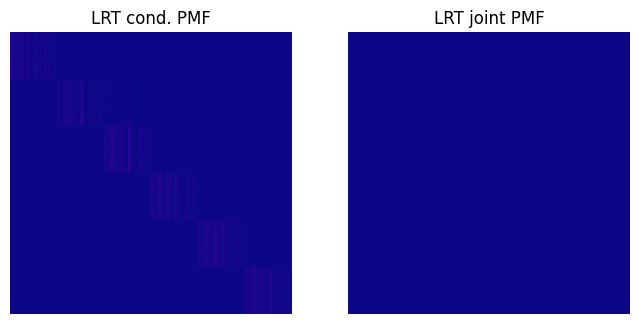

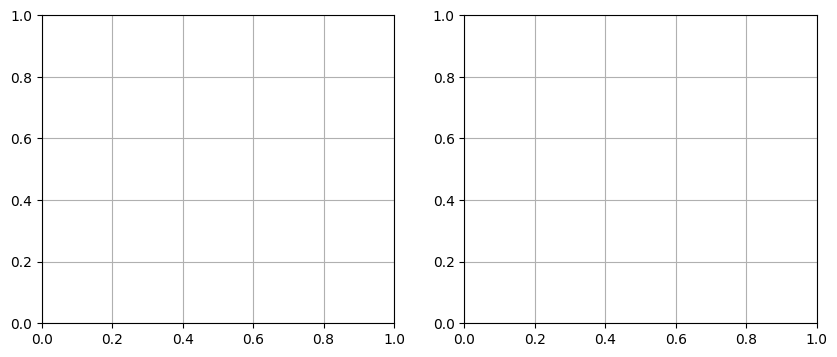

In [43]:
# Low-rank tensor estimation
# T_range = np.logspace(3, 5, 5).astype(int)
T_range = len(sampling_dims)

lrte_est_parallel = lambda lrte, Qh, lrt_args: lrte.estimate(Qh, lrt_args)

eps_abs = 1e-7
eps_rel = 1e-7
eps_diff = 1e-7

lrt_args = {
    'K':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'verbose':verbose,
    'MARG_CONST':True,
    'ACCEL':True
}

lrte = [[LowRankTensorEstimator() for _ in range(T_range)] for _ in range(num_trials)]
# lrt_args['K'] = 50
lrt_args['K'] = 20
lrt_args['beta'] = .01 # .01
lrt_args['max_itr'] = 50_000 # 5_000
results = Parallel(n_jobs=num_cpus)(delayed(lrte_est_parallel)( lrte[t][i],Q_obs[t][i],lrt_args ) for t in range(num_trials) for i in range(T_range))

c = 0
P_1D_lrt = [[None for _ in range(T_range)] for _ in range(num_trials)]
Q_1D_lrt = [[None for _ in range(T_range)] for _ in range(num_trials)]
res_lrt = [[None for _ in range(T_range)] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(T_range):
        P_1D_lrt[t][i] = results[c][0].P_1D
        Q_1D_lrt[t][i] = results[c][0].Q_1D
        res_lrt[t][i] = results[c][1]
        c+=1

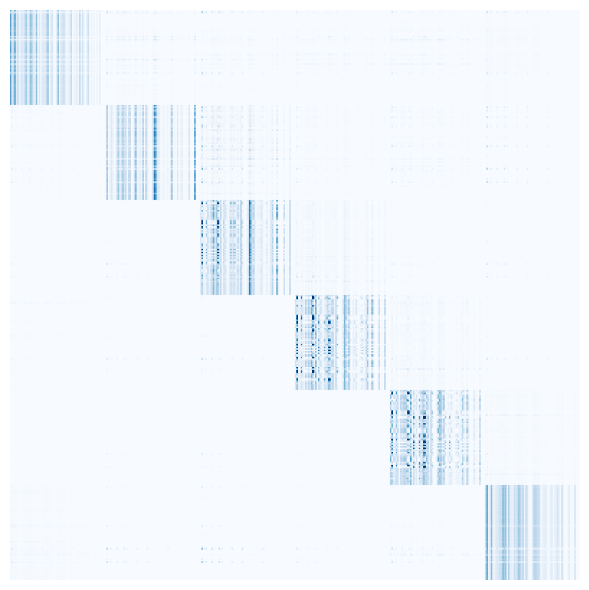

In [60]:
plt.figure(figsize=(12, 6))

plt.imshow(P_1D_lrt[0][0], cmap='Blues', vmin=0, vmax=0.1)
plt.axis('off')

plt.tight_layout()
plt.savefig('results/3_p_lrt', dpi=300)

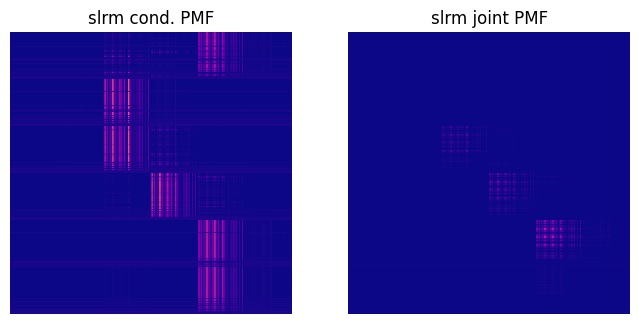

In [50]:
# Spectral low-rank matrix estimation
slrme_est_parallel = lambda slrm,Qh,K: slrm.estimate(Qh,K)

slrme = [[SpecLowRankMatrixEstimator() for _ in range(T_range)] for _ in range(num_trials)]
K_slrme = 3
# results = [[slrme[t][i].estimate(Q_1D_obs[t][i],K_slrme) for i in range(T_range)] for t in range(num_trials)]
results = Parallel(n_jobs=num_cpus)(delayed(slrme_est_parallel)( slrme[t][i],Q_1D_obs[t][i],K_slrme ) for t in range(num_trials) for i in range(T_range))

c = 0
P_1D_slrm = [[None for _ in range(T_range)] for _ in range(num_trials)]
Q_1D_slrm = [[None for _ in range(T_range)] for _ in range(num_trials)]
res_slrm = [[None for _ in range(T_range)] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(T_range):
        P_1D_slrm[t][i] = results[c][0].P
        Q_1D_slrm[t][i] = results[c][0].Q
        res_slrm[t][i] = results[c][1]
        c+=1


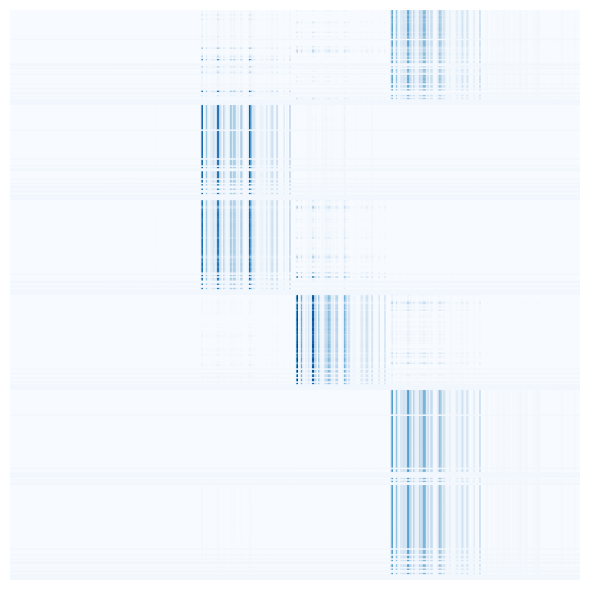

In [61]:
plt.figure(figsize=(12, 6))

plt.imshow(P_1D_slrm[0][0], cmap='Blues', vmin=0, vmax=0.1)
plt.axis('off')

plt.tight_layout()
plt.savefig('results/4_p_spectral_r3', dpi=300)